In [1]:
import time
import torch
from torch.distributions import Categorical, kl_divergence as kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

torch.manual_seed(1234)

lr = 1e-4
EPS = 1e-10
T=5
ALPHA = 0.05
n_heads = 4
device = 'cuda:0'

In [2]:
def cal_kl_loss(heu_mat_list):
    loss = 0
    for i in range(n_heads):
        for j in range(n_heads):
            loss += kl(Categorical(heu_mat_list[i]), Categorical(heu_mat_list[j])).sum()
    loss /= (n_heads * n_heads * heu_mat_list[0].size(0))
    return - ALPHA * loss
    

def train_instance(model, optimizer, pyg_data, distances, n_ants):
    model.train()
    heu_vec_list = model(pyg_data)
    heu_mat_list = [model.reshape(pyg_data, heu_vec_list[i]) + EPS for i in range(n_heads)]
    kl_loss = cal_kl_loss(heu_mat_list)
    
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat_list,
        distances=distances,
        device=device
        )
    
    costs_groups, log_probs_groups = aco.sample()
    loss = 0
    for i in range(n_heads):
        baseline = costs_groups[i].mean()
        reinforce_loss = torch.sum((costs_groups[i] - baseline) * log_probs_groups[i].sum(dim=0)) / (aco.n_ants)
        loss += reinforce_loss
    # print(loss.item(), kl_loss.item())
    loss += kl_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def infer_instance(model, pyg_data, distances, n_ants):
    model.eval()
    heu_vec_list = model(pyg_data)
    heu_mat_list = [model.reshape(pyg_data, heu_vec_list[i]) + EPS for i in range(n_heads)]
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat_list,
        distances=distances,
        device=device
        )
    costs_groups, log_probs_groups = aco.sample()
    costs = torch.cat(costs_groups)
    aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [3]:
def train_epoch(n_node,
                n_ants, 
                k_sparse, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        instance = torch.rand(size=(n_node, 2), device=device)
        data, distances = gen_pyg_data(instance, k_sparse=k_sparse)
        train_instance(net, optimizer, data, distances, n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for data, distances in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, data, distances, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs):
    net = Net(n_heads).to(device)
    net.emb_net.load_state_dict(torch.load(f'../pretrained/tsp/tsp{n_node}.pt', map_location=device), strict=False)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(n_node, k_sparse, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/tsp-spatial/tsp{n_node}.pt')

Learn heuristic for TSP20: 

total training duration: 255.06463956832886
epoch -1: (7.405995945930481, 5.784528856277466, 5.2946227931976315)
epoch 0: (5.285985956192016, 4.272889337539673, 3.954162096977234)
epoch 1: (4.48576322555542, 3.895199751853943, 3.8225194716453554)
epoch 2: (4.364921405315399, 3.8551276326179504, 3.815313625335693)
epoch 3: (4.328296451568604, 3.8556608390808105, 3.8171365213394166)
epoch 4: (4.320535762310028, 3.848262526988983, 3.816536617279053)


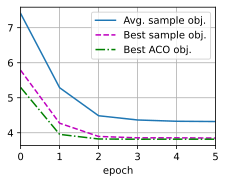

In [5]:
n_node, n_ants = 20, 80
k_sparse = 10
steps_per_epoch = 256
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for TSP100: 

total training duration: 678.6219756603241
epoch -1: (21.396472759246826, 19.06848262786865, 18.166122169494628)
epoch 0: (13.787691068649291, 11.82644624710083, 10.606271677017212)
epoch 1: (10.431559133529664, 9.495988998413086, 8.806430807113648)
epoch 2: (9.91677887916565, 9.012511224746705, 8.515049834251403)
epoch 3: (9.71744197845459, 8.839586677551269, 8.417945876121522)
epoch 4: (9.651369228363038, 8.787889795303345, 8.397069721221923)


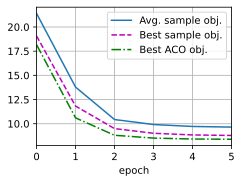

In [6]:
n_node = 100
n_ants = 80
k_sparse = 20
steps_per_epoch = 256
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)